# **🔭StorySeeker Demo**

The model deployed in this notebook was created by Maria Antoniak. See the [central project Github](https://github.com/maria-antoniak/storyseeker) for more information.

Use the 🔭StorySeeker model to predict whether or not a text contains a story.

Please cite the following paper.

> [Where do people tell stories online? Story Detection Across Online Communities](https://aclanthology.org/2024.acl-long.383/)   
> Maria Antoniak, Joel Mire, Maarten Sap, Elliott Ash, Andrew Piper   
> ACL 2024  


<br><br><br><br>

## **Install and import necessary packages**


In [1]:
import torch
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification
from transformers import Trainer, TrainingArguments

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from collections import defaultdict
import gdown
import gzip
import json
import os
import random
import pickle

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
sns.set(style='ticks', font_scale=1.2)

<br><br><br><br>

## **Load StorySeeker model from Hugging Face**

The StorySeeker model is a pretrained RoBERTa model that has been finetuned using our StorySeeker dataset.

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [4]:
device_name = 'cuda'
max_length = 512

In [5]:
tokenizer = AutoTokenizer.from_pretrained("mariaantoniak/storyseeker")
model = AutoModelForSequenceClassification.from_pretrained("mariaantoniak/storyseeker")

In [6]:
trainer = Trainer(model=model)
#trainer.model = model.cuda()

<br><br><br><br>

## **Encode the date and run prediction**

In [7]:
songs = pd.read_csv('songs.csv')
len(songs.index)

15405

In [9]:
lyrics = songs['lyrics'].tolist()

In [10]:
unique_labels = ['not story', 'story']
label2id = {label: id for id, label in enumerate(unique_labels)}
id2label = {id: label for label, id in label2id.items()}

In [11]:
val_encodings  = tokenizer(lyrics, truncation=True, padding=True, max_length=max_length)
val_labels_encoded  = [0]*len(lyrics)

In [12]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [13]:
val_dataset = MyDataset(val_encodings, val_labels_encoded)

In [14]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="tmp_trainer",
    per_device_eval_batch_size=32,  # bump up/down if you hit OOM
    # no no_cuda, no use_mps_device here
)

trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=val_dataset,
    compute_metrics=None,  # faster predict if you just need logits
)

print("Trainer device:", trainer.args.device)  # should say mps
predicted_results = trainer.predict(val_dataset)

Trainer device: mps


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


<br><br><br><br>

## **Examine the prediction output**

Pulling out the labels from the model predictions.

In [15]:
predicted_labels = predicted_results.predictions.argmax(-1)
predicted_labels = predicted_labels.flatten().tolist()
predicted_labels = [id2label[l] for l in predicted_labels]

In [16]:
len(predicted_labels)

15405

In [17]:
songs['predicted_label'] = predicted_labels

In [19]:
songs.sample(10)

,track_id,track_name,track_artist,lyrics,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,language,predicted_label
12594,6hGO839yARUkVnsYG3AkJB,Nowhere,Gavin Haley,Feeling like I can't breathe All these thought...,34,3lflSODQESUQBzjBR3Iqdb,Half Evil,2020-01-08,The Pulse of Indie Poptimism,5qFXOOxrQVyS4UCq3UilZN,...,1,0.0490,0.938000,0.007850,0.1890,0.4450,100.982,155821,en,story
5803,2xTft6GEZeTyWNpdX94rkf,All Eyez On Me,2Pac,"Big Syke, Newt, Hank, Beauregard, Big Sur (yea...",75,4CzT5ueFBRpbILw34HQYxi,All Eyez On Me,1996-02-13,Minitruckin Playlist,0VVH2Nzj6kBVGK3WIUQMAw,...,1,0.2480,0.030000,0.000000,0.3330,0.8580,93.281,307773,en,story
9225,4prKnlKzzw1O8KoxjqExdR,Looking Like This,Lyre Le Temps,"Am I looking like this? Tell me, am I looking ...",52,0cMzi6MjuV1PYZMPHObpJh,Outside the Box,2013-11-11,Electro Swing Top 100,5M7xLCQTYJL0lbKIrUn3a4,...,0,0.1580,0.065700,0.000000,0.1820,0.8290,115.085,214113,en,not story
7555,3uiQZlSlSDRduWLFBTSEot,Don't Start Now - Kungs Remix,Dua Lipa,"If you don't wanna see me Did a full 180, craz...",65,4mzsZJ8apTlyqRRJgJcFY9,Don't Start Now (Kungs Remix),2019-12-18,Dance Room,37i9dQZF1DX2ENAPP1Tyed,...,0,0.2700,0.035200,0.000000,0.0612,0.2520,122.019,216256,en,not story
5730,2wOZ3MzOvz7IPyRSQ6KfXW,Hiding,JR JR,"(burnin,burnin,burnin,burnin,burnin,burnin,bur...",26,3gH9OXHGwEdf1HmY6u4mDR,The Speed of Things,2013-10-08,indie poptimism,1E5VdGGWkpDQ682gdvJAZH,...,1,0.0276,0.024500,0.013300,0.1290,0.5780,89.998,185773,en,not story
5005,2lCdyF2a9EcdBD7C6c99iI,Breathin,2Pac,Who'll be the last motherfucker breathin'? Tel...,1,2lxYSUgQdH38FdZnegAt0f,Until The End Of Time,2001-03-27,Gangsta Rap/90's Hip-Hop,39IFMVQdRNdb7kVfyTvHjM,...,0,0.2880,0.016200,0.000000,0.2100,0.5980,83.015,244827,en,story
11867,61jAJ5ggUq9nDzjc0Yr5CH,Hit Me With Your Best Shot - Remastered,Pat Benatar,NA Well you're the real tough cookie with a lo...,44,4m0tVQEuO296yPLtRQBOV2,Classic Rock,2008-01-01,Classic Rock Workout,37i9dQZF1DWYNSm3Z3MxiM,...,1,0.0297,0.072800,0.000005,0.2520,0.9450,127.434,171133,en,not story
210,07F7zczrjCccG67nrFl3ai,Million Years,Gareth Emery,"I can't see my, see my way through the dark Yo...",0,3Zm13AWIMBpJbwFzenqy9V,Drive,2014-04-01,Female Vocal EDM,5QaPRbVgbEcCc9jC1UxgD1,...,1,0.0628,0.025200,0.001320,0.0430,0.0700,127.916,243278,en,not story
6093,3528IXKpbb7OMjdjWYlbfD,Everybody Talks,Neon Trees,Hey baby won't you look my way I can be your n...,65,7hPNlDBLv1EW8GakiIzFnn,Picture Show (Deluxe Edition),2012-01-01,Dr. Q's Prescription Playlist💊,6jAPdgY9XmxC9cgkXAVmVv,...,1,0.0586,0.003010,0.000000,0.3130,0.7250,154.961,177280,en,story
10599,5gTyK0ylsqQbhFugP7eYmz,Stay Forever (feat. STRFKR),Whethan,I don't want to live all the way with a throw ...,62,1x535ZgCy1Zf2VZoOQ66Jm,Stay Forever (feat. STRFKR),2020-01-10,The Pulse of Indie Poptimism,5qFXOOxrQVyS4UCq3UilZN,...,1,0.0334,0.000033,0.826000,0.0912,0.0656,117.932,153430,en,not story


In [22]:
stories = [_text for _predicted_label, _text in zip(predicted_labels, lyrics) if _predicted_label == 'story']
non_stories = [_text for _predicted_label, _text in zip(predicted_labels, lyrics) if _predicted_label == 'not story']

In [23]:
len(stories), len(non_stories)

(4835, 10570)

<br><br><br><br>

## **Build Embeddings for Lyrics and Visualize the Clusters**

Batches: 100%|██████████| 482/482 [01:35<00:00,  5.04it/s]
/opt/anaconda3/envs/py311/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


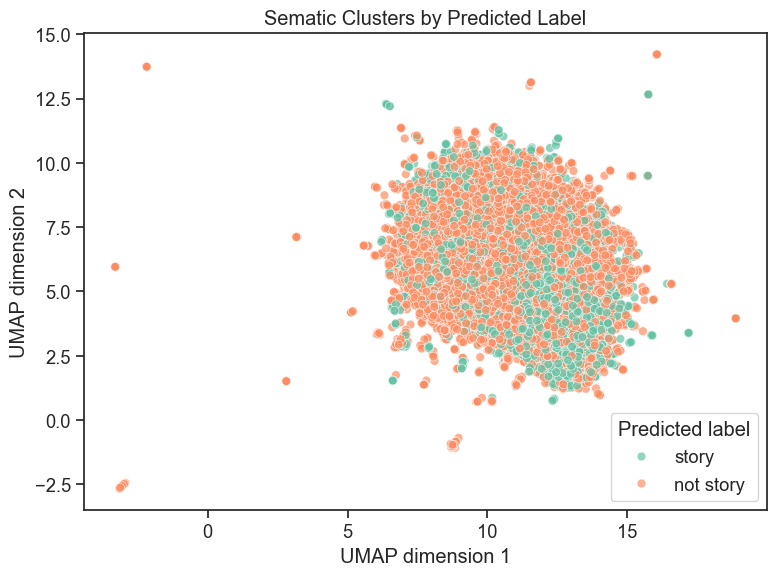

In [29]:
import umap
import seaborn as sns
from sentence_transformers import SentenceTransformer

# Choose device (MPS on M3 if available)
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

# Load SentenceTransformer model
model_name = "sentence-transformers/all-MiniLM-L6-v2"
st_model = SentenceTransformer(model_name, device=device)

# Compute embeddings for all lyrics
embeddings = st_model.encode(
    lyrics,
    batch_size=32,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=False,
)

# Reduce to 2D with UMAP
reducer = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.3,
    metric="cosine",
    random_state=42,
)
embedding_2d = reducer.fit_transform(embeddings)
songs["x"] = embedding_2d[:, 0]
songs["y"] = embedding_2d[:, 1]

# Plot clusters colored by predicted_label
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=songs,
    x="x",
    y="y",
    hue="predicted_label",     
    palette="Set2",
    alpha=0.7,
    s=40,
)
plt.title("Sematic Clusters by Predicted Label")
plt.xlabel("UMAP dimension 1")
plt.ylabel("UMAP dimension 2")
plt.legend(title="Predicted label")
plt.tight_layout()
plt.show()


<br><br><br><br>

## **Examine Correlation with LIWC Metrics**

In [26]:
songs_liwc = pd.read_csv('songs_liwc.csv')
songs_liwc['predicted_label'] = predicted_labels
songs_liwc["label_dummy"] = songs_liwc["predicted_label"].map({"not story": 0, "story": 1})

In [27]:
corrs = songs_liwc[["label_dummy", "Analytic", "Linguistic", "Cognition"]].corr()
corrs

,label_dummy,Analytic,Linguistic,Cognition
label_dummy,1.000000,0.093099,-0.065085,-0.138535
Analytic,0.093099,1.000000,-0.537843,-0.603323
Linguistic,-0.065085,-0.537843,1.000000,0.549755
Cognition,-0.138535,-0.603323,0.549755,1.000000


/var/folders/6l/cmpq4f_96xv7_3p8k362lbnr0000gn/T/ipykernel_2971/3066157199.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=songs_liwc, x="predicted_label", y=var, palette="Set2", ax=ax)
/var/folders/6l/cmpq4f_96xv7_3p8k362lbnr0000gn/T/ipykernel_2971/3066157199.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=songs_liwc, x="predicted_label", y=var, palette="Set2", ax=ax)
/var/folders/6l/cmpq4f_96xv7_3p8k362lbnr0000gn/T/ipykernel_2971/3066157199.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=songs_liwc, x="predicted_

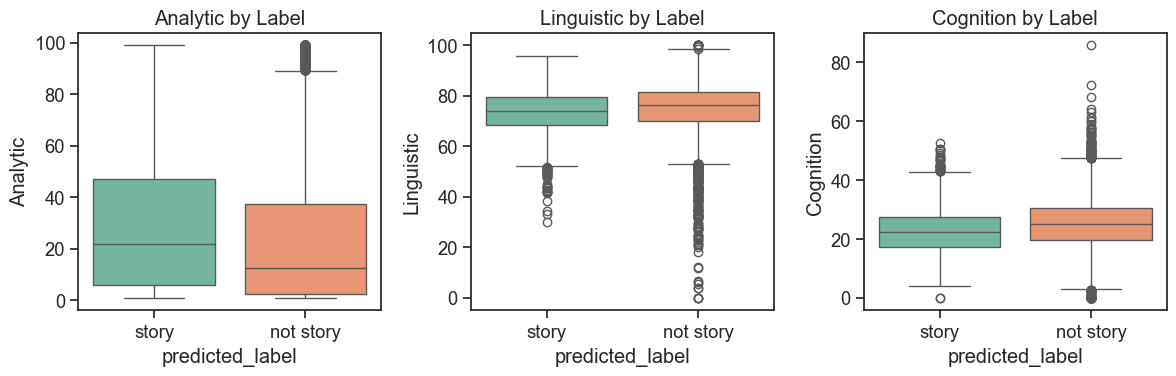

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))

for ax, var in zip(axes, ["Analytic", "Linguistic", "Cognition"]):
    sns.boxplot(data=songs_liwc, x="predicted_label", y=var, palette="Set2", ax=ax)
    ax.set_title(f"{var} by Label")

plt.tight_layout()
plt.show()
